# STFT

In [1]:
import torch, torchvision
from torchvision import transforms
from torch import nn
import numpy as np
import sys
import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
stft_data = np.load('/content/drive/MyDrive/EEG/DEAP/stft_emo.npy')
targets = np.load('/content/drive/MyDrive/EEG/DEAP/targets.npy')

In [3]:
valence = []
mean_valence = np.mean(targets[:,0])
for i in range(targets.shape[0]):
  if targets[i,0] < mean_valence :
    valence.append(0)
  else :
    valence.append(1)
valence = np.array(valence)
valence.shape

(1280,)

In [ ]:
valence.shape

(1280,)

In [ ]:
#from tensorflow.keras.utils import to_categorical
#valence = to_categorical(valence)
#valence.shape

(1280, 2)

In [4]:
x_train = stft_data[:896]
x_val =  stft_data[896:896+128]
x_test = stft_data[896+128:]

y_train = valence[:896]
y_val = valence[896:896+128]
y_test = valence[896+128:]

In [115]:
x_train = stft_data[:28]
x_val =  stft_data[28:32]
x_test = stft_data[32:40]

y_train = valence[:28]
y_val = valence[28:32]
y_test = valence[32:40]

# DataLoader 

In [130]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 4
def dataload(X, y):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y)
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    return dataset_tensor
    #return DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)

train_loader = DataLoader(dataload(x_train, y_train), batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(dataload(x_val, y_val), batch_size=batch_size, shuffle=False)

test_loader = DataLoader(dataload(x_test, y_test), batch_size=batch_size, shuffle=False)

# Conv2d model

In [131]:
num_epochs = 100
num_classes = 2
learning_rate = 0.0001

In [132]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(ConvNet, self).__init__()
        

        #stft_data.shape[1] = number of channel
        self.layer1 = nn.Sequential(
            nn.Conv2d(stft_data.shape[1], 256, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(256),
            nn.RLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        """self.fc = nn.Sequential(nn.Linear(128*16*7,512),nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(512,250),nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(250,125),nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(125,50),nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(50,num_classes),nn.Dropout(0.1))"""
        
        self.fc = nn.Linear(512*16*31, num_classes)
        #self.fc = nn.Sequential(nn.Linear(256*8*15,256),nn.ELU(),nn.Dropout(0.1),
                               #nn.Linear(256,num_classes),nn.Dropout(0.1))
        self.drop_out = nn.Dropout(p=0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        #out = self.layer3(out)
        #out = self.drop_out(out)
        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        out = self.softmax(out)
        return out

In [133]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) #<---here

In [134]:
model = ConvNet(num_classes).float()
model.apply(initialize_weights)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(16, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=253952, out_features=2, bias=True)
  (drop_out): Dropout

In [135]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

# Train Test 

In [136]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [137]:
def cnn_acc(preds,y):
    _, predicted = torch.max(preds.data, 1)
    correct = (predicted == y).sum()
    acc = correct / y.size(0)
    return acc

In [138]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (features, label) in enumerate(loader): 
                
        #predict
        predictions = model(features)
        #calculate loss
        loss = criterion(predictions, label)
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm
        acc = cnn_acc(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [139]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (features, label) in enumerate(loader): 


            predictions = model(features)
            
            loss = criterion(predictions, label)
            acc = cnn_acc(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [140]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss,valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'tensor.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 15.803 | Train Acc: 57.14%
	 Val. Loss: 40.703 |  Val. Acc: 0.00%
Epoch: 02 | Train Loss: 6.537 | Train Acc: 64.29%
	 Val. Loss: 9.171 |  Val. Acc: 0.00%
Epoch: 03 | Train Loss: 3.640 | Train Acc: 85.71%
	 Val. Loss: 0.669 |  Val. Acc: 50.00%
Epoch: 04 | Train Loss: 3.600 | Train Acc: 85.71%
	 Val. Loss: 0.334 |  Val. Acc: 100.00%
Epoch: 05 | Train Loss: 3.571 | Train Acc: 89.29%
	 Val. Loss: 10.810 |  Val. Acc: 0.00%
Epoch: 06 | Train Loss: 3.105 | Train Acc: 92.86%
	 Val. Loss: 1.182 |  Val. Acc: 50.00%
Epoch: 07 | Train Loss: 3.012 | Train Acc: 92.86%
	 Val. Loss: 2.380 |  Val. Acc: 25.00%
Epoch: 08 | Train Loss: 2.948 | Train Acc: 100.00%
	 Val. Loss: 8.181 |  Val. Acc: 0.00%
Epoch: 09 | Train Loss: 2.913 | Train Acc: 100.00%
	 Val. Loss: 2.416 |  Val. Acc: 25.00%
Epoch: 10 | Train Loss: 2.889 | Train Acc: 100.00%
	 Val. Loss: 0.600 |  Val. Acc: 50.00%
Epoch: 11 | Train Loss: 2.876 | Train Acc: 100.00%
	 Val. Loss: 0.252 |  Val. Acc: 100.00%
Epoch: 12 | Trai

Text(0, 0.5, 'loss')

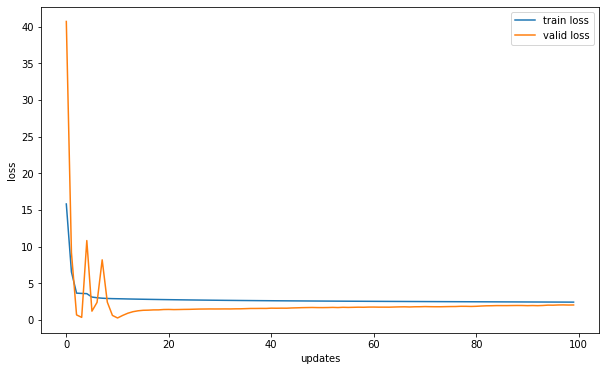

In [141]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

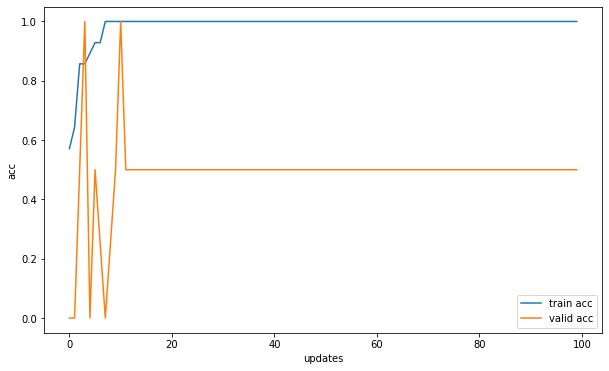

In [142]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [143]:
model.load_state_dict(torch.load('tensor.pt'))
test_loss , test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.201 | Test Acc: 100.00%
